In [3]:
"""
Title: Full Preprocessing, Feature Engineering, and Modeling Pipeline for Hospital Bed Utilization

Description:
This script performs the complete data pipeline for analyzing and modeling hospital bed utilization rates
using social determinants of health (SDOH) and geographic access features. The workflow includes:

1. Data Loading and Initial Exploration
2. Preprocessing and Filtering (e.g., region/state exclusions, missing data handling)
3. Feature Engineering:
   - One-hot encoding of Region
   - Target encoding of State
   - Binary encoding and KNN imputation for Is_Metro_Micro
4. Data Standardization
5. Train-Test Splitting using calculated ratio
6. Export of final datasets:
   - Full dataset with preserved missing targets
   - Modeling-only dataset (no missing targets)
7. Normality Assessment (Shapiro-Wilk, Q-Q Plot, KDE)
8. Box-Cox transformation for target normalization (optional step)
9. Predictive Modeling:
   - Ridge and Lasso Regression (pre- and post-transformation)
   - Residual analysis and diagnostic testing (Shapiro-Wilk, Breusch-Pagan)
10. Export of modeling-ready files and visualizations

Inputs:
- `MERGED_SDOH_PLUS_UTIL_24_RenamedColumns.csv`: Raw merged dataset with renamed variables

Outputs:
- `final_full_dataset_with_preserved_missing_targets.xlsx`: Full dataset with encoded, imputed values
- `modeling_dataset_only.xlsx`: Cleaned and ready dataset for modeling without missing targets

Note:
- Target variable: `Bed_util_ratio`
- Special handling applied to: `Is_Metro_Micro`, `State`, and `Region`
- Box-Cox applied to transform target variable when required
- Residual diagnostics included to evaluate assumptions of regression models
"""



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading and Initial Exploration

In [4]:
df = pd.read_csv('/content/MERGED_SDOH_PLUS_UTIL_24_RenamedColumns.csv')
df.head()

,CountyFIPS,State,County,Region,Pct_renter_occupied,Distance_to_medsurge_icu,Pct_renter_cost_50pct_plus,Pct_renter_cost_30pct_plus,Total_population_poverty,Pct_owner_cost_30plus,...,Pct_age_65plus,Pct_homes_no_vehicle,Pct_public_transit,Pct_single_parent,Pct_hh_no_internet,Distance_to_ED,Pct_mobile_homes,Pct_disabled,Is_Metro_Micro,Bed_util_ratio
0,1001,Alabama,Autauga County,South,24.941176,5.352941,28.352941,43.176470,55181.0,19.588235,...,15.352941,5.294117,0.470588,27.411764,82.352941,5.294117,17.882352,17.470588,1.0,0.378106
1,1003,Alabama,Baldwin County,South,22.727272,7.500000,19.545454,43.795454,215170.0,20.227272,...,21.681818,3.090909,0.045454,20.386363,83.204545,6.409090,12.159090,13.977272,1.0,0.504948
2,1005,Alabama,Barbour County,South,37.888888,8.666666,20.666666,46.222222,22070.0,16.333333,...,19.777777,11.888888,0.111111,47.777777,65.000000,8.666666,27.888888,19.111111,1.0,0.284690
3,1007,Alabama,Bibb County,South,24.500000,21.250000,27.750000,49.625000,20748.0,13.250000,...,16.250000,5.750000,0.000000,31.750000,74.875000,8.500000,33.250000,18.000000,1.0,0.286999
4,1009,Alabama,Blount County,South,24.062500,9.750000,23.562500,47.875000,57127.0,15.187500,...,18.500000,5.375000,0.125000,26.062500,80.187500,9.625000,25.500000,15.000000,1.0,0.304907


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3238 entries, 0 to 3237
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CountyFIPS                  3238 non-null   int64  
 1   State                       3238 non-null   object 
 2   County                      3233 non-null   object 
 3   Region                      3142 non-null   object 
 4   Pct_renter_occupied         3233 non-null   float64
 5   Distance_to_medsurge_icu    3233 non-null   float64
 6   Pct_renter_cost_50pct_plus  3233 non-null   float64
 7   Pct_renter_cost_30pct_plus  3233 non-null   float64
 8   Total_population_poverty    3233 non-null   float64
 9   Pct_owner_cost_30plus       3233 non-null   float64
 10  Population_density          3233 non-null   float64
 11  Land_area_sqmi              3233 non-null   float64
 12  Median_hh_income            3233 non-null   float64
 13  Pct_hh_65_alone             3233 

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CountyFIPS,3238.0,31510.994750,16461.588197,1001.000000,19033.500000,30034.000000,46126.500000,7.803000e+04
Pct_renter_occupied,3233.0,26.772991,9.621379,0.000000,21.333333,26.000000,31.793103,8.200000e+01
Distance_to_medsurge_icu,3233.0,12.576584,17.666859,0.000000,4.666666,7.300000,16.500000,4.870000e+02
Pct_renter_cost_50pct_plus,3233.0,18.631243,7.792021,0.000000,14.282352,18.833333,23.285714,7.500000e+01
Pct_renter_cost_30pct_plus,3233.0,39.681103,12.038323,0.000000,34.000000,41.000000,46.764705,1.000000e+02
Total_population_poverty,3233.0,98328.190226,322366.187705,0.000000,9612.000000,23544.000000,63303.000000,9.884138e+06
Pct_owner_cost_30plus,3233.0,17.704513,5.730698,0.000000,14.833333,17.500000,20.682352,4.275000e+01
Population_density,3233.0,885.225238,2777.821857,0.000000,41.500000,209.000000,906.500000,9.038623e+04
Land_area_sqmi,3233.0,289.474886,1297.173269,0.000000,27.928571,72.000000,173.500000,3.639325e+04
Median_hh_income,3233.0,53790.007733,17717.600213,0.000000,44620.000000,52881.000000,61822.000000,1.485230e+05


In [7]:
df.isna().sum()

,0
CountyFIPS,0
State,0
County,5
Region,96
Pct_renter_occupied,5
Distance_to_medsurge_icu,5
Pct_renter_cost_50pct_plus,5
Pct_renter_cost_30pct_plus,5
Total_population_poverty,5
Pct_owner_cost_30plus,5


In [8]:
# Display structure and summary
print(df.shape)
print(df.dtypes.value_counts())

(3238, 24)
float64    20
object      3
int64       1
Name: count, dtype: int64


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3238 entries, 0 to 3237
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CountyFIPS                  3238 non-null   int64  
 1   State                       3238 non-null   object 
 2   County                      3233 non-null   object 
 3   Region                      3142 non-null   object 
 4   Pct_renter_occupied         3233 non-null   float64
 5   Distance_to_medsurge_icu    3233 non-null   float64
 6   Pct_renter_cost_50pct_plus  3233 non-null   float64
 7   Pct_renter_cost_30pct_plus  3233 non-null   float64
 8   Total_population_poverty    3233 non-null   float64
 9   Pct_owner_cost_30plus       3233 non-null   float64
 10  Population_density          3233 non-null   float64
 11  Land_area_sqmi              3233 non-null   float64
 12  Median_hh_income            3233 non-null   float64
 13  Pct_hh_65_alone             3233 

# Final Data Preprocessing and Feature Engineering Pipeline (with One-Hot Encoding, Target Encoding, and KNN Imputation for Is_Metro_Micro Only)

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

# Train-test split calculator
def calcSplitRatio(df, p=None):
    if p is None:
        p = df.shape[1] - 1
    test_N = (1 / np.sqrt(p)) * len(df)
    test_prop = round(test_N / len(df), 2)
    train_prop = 1 - test_prop
    print(f"\nCalculated train/test split: {train_prop:.2f}/{test_prop:.2f}")
    return train_prop

# Filter and split full dataset
df_cleaned = df.dropna(subset=["Region"])
df_cleaned = df_cleaned[df_cleaned["State"] != "District of Columbia"]

predictor_cols = [col for col in df_cleaned.columns if col not in ["Bed_util_ratio", "Is_Metro_Micro"]]
df_cleaned = df_cleaned.dropna(subset=predictor_cols)

# Split into: with-target (for modeling) vs. missing-target (for our preservation)
df_modeling = df_cleaned[df_cleaned["Bed_util_ratio"].notnull()].copy()
df_missing_target = df_cleaned[df_cleaned["Bed_util_ratio"].isnull()].copy()

print(f"Modeling dataset shape (non-missing target): {df_modeling.shape}")
print(f"Rows with missing Bed_util_ratio preserved separately: {df_missing_target.shape}")

# Train-test split
X = df_modeling.drop(columns=["Bed_util_ratio"])
y = df_modeling["Bed_util_ratio"]
split_ratio = calcSplitRatio(df_modeling)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split_ratio, random_state=42)

# Encoding
# Binary encode Is_Metro_Micro
for subset in [X_train, X_test]:
    subset["Is_Metro_Micro"] = subset["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan})

# Target encode State
state_target_mean = y_train.groupby(X_train["State"]).mean()
X_train["state_encoded"] = X_train["State"].map(state_target_mean)
X_test["state_encoded"] = X_test["State"].map(state_target_mean)

# One-hot encode Region
X_train = pd.get_dummies(X_train, columns=["Region"], prefix="Region", drop_first=True)
X_test = pd.get_dummies(X_test, columns=["Region"], prefix="Region", drop_first=True)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Drop unused columns
X_train = X_train.drop(columns=["CountyFIPS", "County", "State"])
X_test = X_test.drop(columns=["CountyFIPS", "County", "State"])

# Scaling + Imputation for Is_Metro_Micro only
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# KNN Impute Is_Metro_Micro
knn = KNNImputer(n_neighbors=5)
X_train_scaled["Is_Metro_Micro"] = knn.fit_transform(X_train_scaled[["Is_Metro_Micro"]])
X_test_scaled["Is_Metro_Micro"] = knn.transform(X_test_scaled[["Is_Metro_Micro"]])

# Reattach target
train_final = X_train_scaled.copy()
train_final["Bed_util_ratio"] = y_train
test_final = X_test_scaled.copy()
test_final["Bed_util_ratio"] = y_test

# Combine for modeling dataset
df_model_imputed = pd.concat([train_final, test_final]).sort_index()
df_model_imputed["Is_Metro_Micro"] = (df_model_imputed["Is_Metro_Micro"] >= 0.5).astype(int)

print("\nModeling dataset ready with imputed Is_Metro_Micro and non-imputed Bed_util_ratio.")
print(df_model_imputed.head())

# Append back missing-target rows for full dataset view
# We just encode + scale them similarly (skip splitting)
df_missing_target_encoded = df_missing_target.copy()

# Binary encode Is_Metro_Micro
df_missing_target_encoded["Is_Metro_Micro"] = df_missing_target_encoded["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan})

# Target encode State using same map
df_missing_target_encoded["state_encoded"] = df_missing_target_encoded["State"].map(state_target_mean)

# One-hot encode Region and align
df_missing_target_encoded = pd.get_dummies(df_missing_target_encoded, columns=["Region"], prefix="Region", drop_first=True)
df_missing_target_encoded = df_missing_target_encoded.reindex(columns=X_train.columns.union(["state_encoded", "Is_Metro_Micro"]), fill_value=0)

# Standardize numeric
df_missing_scaled = df_missing_target_encoded.copy()

# Ensure we only transform the same columns used during fit
# reorder + subset
df_missing_scaled = df_missing_scaled[X_train.columns]
df_missing_scaled = pd.DataFrame(scaler.transform(df_missing_scaled), columns=X_train.columns, index=df_missing_scaled.index)


# Impute Is_Metro_Micro
df_missing_scaled["Is_Metro_Micro"] = knn.transform(df_missing_scaled[["Is_Metro_Micro"]])
df_missing_scaled["Is_Metro_Micro"] = (df_missing_scaled["Is_Metro_Micro"] >= 0.5).astype(int)

# Add placeholder Bed_util_ratio = NaN
df_missing_scaled["Bed_util_ratio"] = np.nan

# Final full dataset
df_final_full = pd.concat([df_model_imputed, df_missing_scaled], axis=0).sort_index()
print(f"\nFull dataset shape after re-integration: {df_final_full.shape}")
print(df_final_full.head())

# Export if needed
df_final_full.to_excel("final_full_dataset_with_preserved_missing_targets.xlsx", index=False)
print("\nExported full dataset with missing targets preserved.")

# Export Modeling-Only Dataset (no missing Bed_util_ratio)
df_model_imputed.to_excel("modeling_dataset_only.xlsx", index=False)
print("Exported: modeling_dataset_only.xlsx")


Modeling dataset shape (non-missing target): (2391, 24)
Rows with missing Bed_util_ratio preserved separately: (751, 24)

Calculated train/test split: 0.79/0.21

Modeling dataset ready with imputed Is_Metro_Micro and non-imputed Bed_util_ratio.
   Pct_renter_occupied  Distance_to_medsurge_icu  Pct_renter_cost_50pct_plus  \
0            -0.427518                 -0.471124                    1.383576   
1            -0.701126                 -0.248484                    0.013291   
2             1.172644                 -0.127506                    0.187731   
3            -0.482041                  1.177327                    1.289770   
4            -0.536110                 -0.015169                    0.638270   

   Pct_renter_cost_30pct_plus  Total_population_poverty  \
0                    0.231582                 -0.186281   
1                    0.301195                  0.256987   
2                    0.574114                 -0.278018   
3                    0.956798         

In [12]:
X_train_scaled.isnull().sum()

,0
Pct_renter_occupied,0
Distance_to_medsurge_icu,0
Pct_renter_cost_50pct_plus,0
Pct_renter_cost_30pct_plus,0
Total_population_poverty,0
Pct_owner_cost_30plus,0
Population_density,0
Land_area_sqmi,0
Median_hh_income,0
Pct_hh_65_alone,0


In [13]:
X_test_scaled.isnull().sum()

,0
Pct_renter_occupied,0
Distance_to_medsurge_icu,0
Pct_renter_cost_50pct_plus,0
Pct_renter_cost_30pct_plus,0
Total_population_poverty,0
Pct_owner_cost_30plus,0
Population_density,0
Land_area_sqmi,0
Median_hh_income,0
Pct_hh_65_alone,0


In [14]:
len(X_train_scaled), len(X_test_scaled)

(1888, 503)

# Histogram of Bed_util_ratio - Train vs Test (No Imputation)

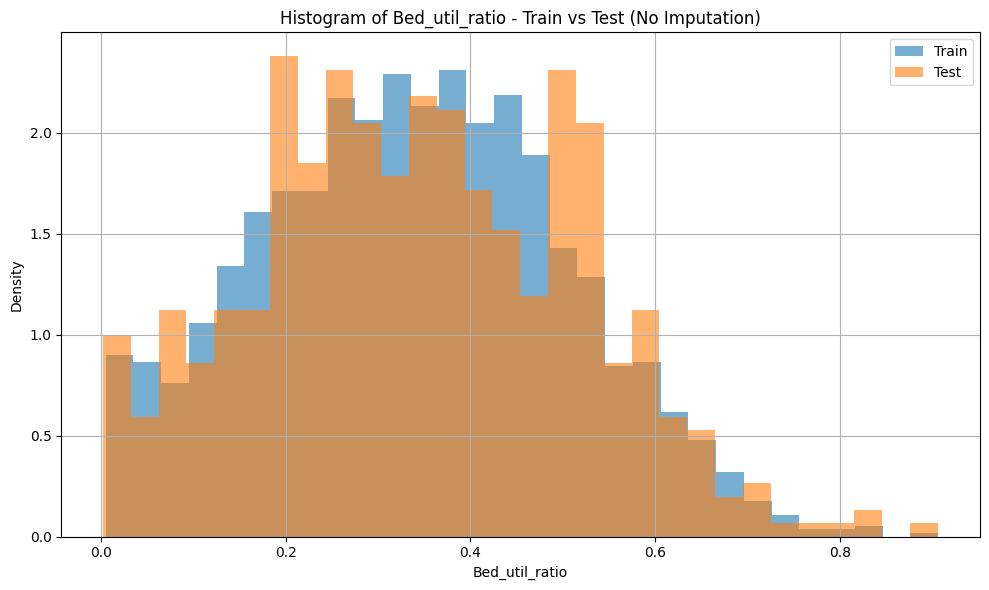

In [15]:
# === Histogram of Bed_util_ratio - Train vs Test (No Imputation) ===
plt.figure(figsize=(10, 6))
plt.hist(train_final["Bed_util_ratio"], bins=30, alpha=0.6, label="Train", density=True)
plt.hist(test_final["Bed_util_ratio"], bins=30, alpha=0.6, label="Test", density=True)
plt.title("Histogram of Bed_util_ratio - Train vs Test (No Imputation)")
plt.xlabel("Bed_util_ratio")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# BarPlot - Imputation Comparison for Is_Metro_Micro

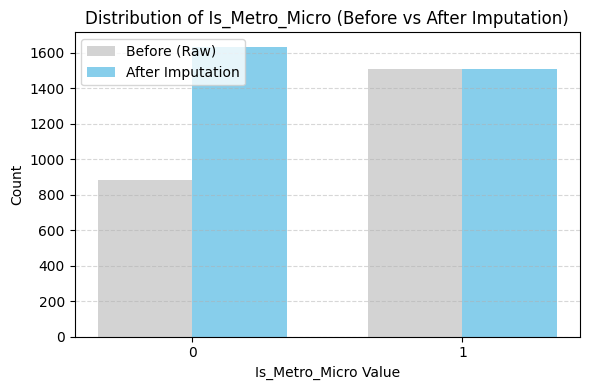

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Before imputation: include NaNs
before = df_cleaned["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan}).value_counts(dropna=False)
before.index = before.index.astype("object")  # so NaN label is retained

# After imputation: should be only 0 and 1
after = df_final_full["Is_Metro_Micro"].value_counts()

# Align both to 0 and 1 only (for bar chart)
x_labels = [0, 1]
before_aligned = [before.get(0, 0), before.get(1, 0)]
after_aligned = [after.get(0, 0), after.get(1, 0)]

# Plot
bar_width = 0.35
x = np.arange(len(x_labels))

plt.figure(figsize=(6, 4))
plt.bar(x - bar_width/2, before_aligned, width=bar_width, label="Before (Raw)", color="lightgray")
plt.bar(x + bar_width/2, after_aligned, width=bar_width, label="After Imputation", color="skyblue")

plt.xticks(ticks=x, labels=["0", "1"])
plt.xlabel("Is_Metro_Micro Value")
plt.ylabel("Count")
plt.title("Distribution of Is_Metro_Micro (Before vs After Imputation)")
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Shapiro-Wilk W Statistic for Bed_util_ratio

In [17]:
from scipy.stats import shapiro

# Run only on non-null values
target_values = df_final_full["Bed_util_ratio"].dropna()

# Perform Shapiro-Wilk test
stat, p = shapiro(target_values)

print("Shapiro-Wilk W Statistic:", stat)
print("p-value:", p)

if p > 0.05:
    print("Target appears normally distributed (fail to reject H0)")
else:
    print("Target likely not normally distributed (reject H0)")


Shapiro-Wilk W Statistic: 0.9919237932068726
p-value: 2.821064526072581e-10
Target likely not normally distributed (reject H0)


In [18]:
Shapiro_Result = """We conducted a Shapiro-Wilk test on Bed_util_ratio to assess normality. \nThe resulting W statistic was 0.992 with a p-value < 0.001, indicating the distribution is not normal. \nThis insight may inform downstream modeling choices (e.g., transformation before regularized regression). \nSince our primary modeling approach includes methods that do not assume normality (e.g., tree-based or clustering models), \nwe retained the raw distribution of the target for now."""
print(Shapiro_Result)

We conducted a Shapiro-Wilk test on Bed_util_ratio to assess normality. 
The resulting W statistic was 0.992 with a p-value < 0.001, indicating the distribution is not normal. 
This insight may inform downstream modeling choices (e.g., transformation before regularized regression). 
Since our primary modeling approach includes methods that do not assume normality (e.g., tree-based or clustering models), 
we retained the raw distribution of the target for now.


# Distribution of Bed_Util_Ratio w/ KDE

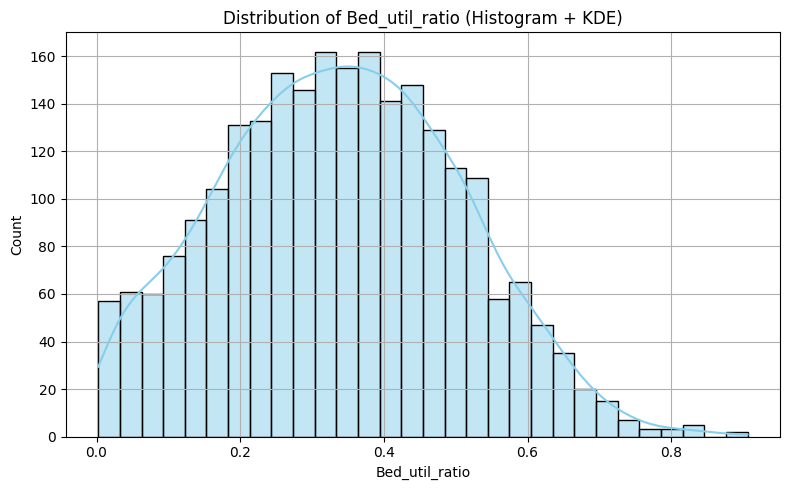

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop missing target values
bed_util_values = df_final_full["Bed_util_ratio"].dropna()

# Plot histogram
plt.figure(figsize=(8, 5))
sns.histplot(bed_util_values, kde=True, bins=30, color="skyblue")
plt.title("Distribution of Bed_util_ratio (Histogram + KDE)")
plt.xlabel("Bed_util_ratio")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()


# Q-Q Plot for Normality Check

<Figure size 600x600 with 0 Axes>

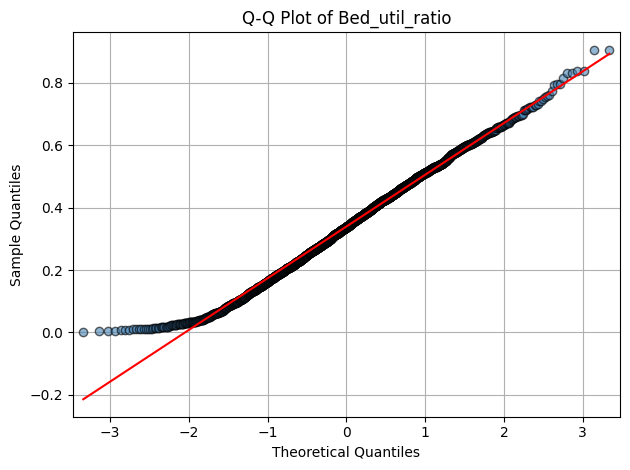

In [20]:
import statsmodels.api as sm
import scipy.stats as stats

# Drop missing target values
bed_util_values = df_final_full["Bed_util_ratio"].dropna()

# QQ plot
plt.figure(figsize=(6, 6))
sm.qqplot(bed_util_values, line="s", markerfacecolor='steelblue', markeredgecolor='black', alpha=0.6)
plt.title("Q-Q Plot of Bed_util_ratio")
plt.grid(True)
plt.tight_layout()
plt.show()


# Post-Transformation Analysis

# Box-Cox Normalization + (Shapiro-Wilk Test & Bed_util_ratio)

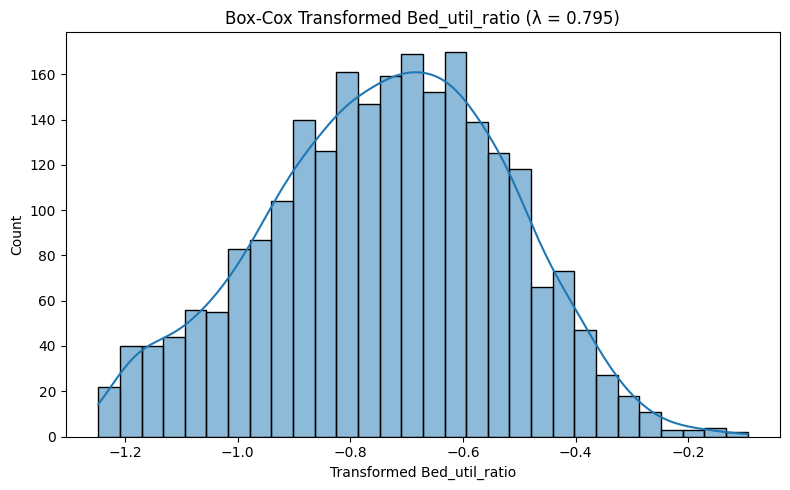


Shapiro-Wilk Test (after Box-Cox):
W statistic: 0.99314
p-value:     3.66059e-09
Target likely not normally distributed (reject H0)
Modeling dataset shape (non-missing target): (2391, 24)
Rows with missing Bed_util_ratio preserved separately: (751, 24)

Calculated train/test split: 0.79/0.21

Modeling dataset ready with imputed Is_Metro_Micro and non-imputed Bed_util_ratio.
   Pct_renter_occupied  Distance_to_medsurge_icu  Pct_renter_cost_50pct_plus  \
0            -0.427518                 -0.471124                    1.383576   
1            -0.701126                 -0.248484                    0.013291   
2             1.172644                 -0.127506                    0.187731   
3            -0.482041                  1.177327                    1.289770   
4            -0.536110                 -0.015169                    0.638270   

   Pct_renter_cost_30pct_plus  Total_population_poverty  \
0                    0.231582                 -0.186281   
1                    0.

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

# Train-test split calculator
def calcSplitRatio(df, p=None):
    if p is None:
        p = df.shape[1] - 1
    test_N = (1 / np.sqrt(p)) * len(df)
    test_prop = round(test_N / len(df), 2)
    train_prop = 1 - test_prop
    print(f"\nCalculated train/test split: {train_prop:.2f}/{test_prop:.2f}")
    return train_prop

# Filter and split full dataset
df_cleaned = df.dropna(subset=["Region"])
df_cleaned = df_cleaned[df_cleaned["State"] != "District of Columbia"]

predictor_cols = [col for col in df_cleaned.columns if col not in ["Bed_util_ratio", "Is_Metro_Micro"]]
df_cleaned = df_cleaned.dropna(subset=predictor_cols)

# Split into: with-target (for modeling) vs. missing-target (for our preservation)
df_modeling = df_cleaned[df_cleaned["Bed_util_ratio"].notnull()].copy()
df_missing_target = df_cleaned[df_cleaned["Bed_util_ratio"].isnull()].copy()

# --------------------------------------------------------------
# ADDED NORMALIZATION FOR TARGET (BOX-COX)
from scipy.stats import boxcox, shapiro
import seaborn as sns

# Drop NaNs from target
target_raw = df_modeling["Bed_util_ratio"].dropna()

# Check for any values ≤ 0
if (target_raw <= 0).any():
    print("Box-Cox requires all values > 0 — applying small offset")
    target_shifted = target_raw + 1e-4
else:
    target_shifted = target_raw.copy()

# Box-Cox Transformation
target_bc, lambda_bc = boxcox(target_shifted)

# Plot distribution
plt.figure(figsize=(8, 5))
sns.histplot(target_bc, bins=30, kde=True)
plt.title(f"Box-Cox Transformed Bed_util_ratio (λ = {lambda_bc:.3f})")
plt.xlabel("Transformed Bed_util_ratio")
plt.tight_layout()
plt.show()

# Shapiro-Wilk Test
stat, p = shapiro(target_bc)
print("\nShapiro-Wilk Test (after Box-Cox):")
print(f"W statistic: {stat:.5f}")
print(f"p-value:     {p:.5e}")

if p > 0.05:
    print("Target appears normally distributed (fail to reject H0)")
else:
    print("Target likely not normally distributed (reject H0)")

# ------------------------------------------------------------------------

print(f"Modeling dataset shape (non-missing target): {df_modeling.shape}")
print(f"Rows with missing Bed_util_ratio preserved separately: {df_missing_target.shape}")

# Train-test split
X = df_modeling.drop(columns=["Bed_util_ratio"])
y = df_modeling["Bed_util_ratio"]
split_ratio = calcSplitRatio(df_modeling)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split_ratio, random_state=42)

# Encoding
# Binary encode Is_Metro_Micro
for subset in [X_train, X_test]:
    subset["Is_Metro_Micro"] = subset["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan})

# Target encode State
state_target_mean = y_train.groupby(X_train["State"]).mean()
X_train["state_encoded"] = X_train["State"].map(state_target_mean)
X_test["state_encoded"] = X_test["State"].map(state_target_mean)

# One-hot encode Region
X_train = pd.get_dummies(X_train, columns=["Region"], prefix="Region", drop_first=True)
X_test = pd.get_dummies(X_test, columns=["Region"], prefix="Region", drop_first=True)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Drop unused columns
X_train = X_train.drop(columns=["CountyFIPS", "County", "State"])
X_test = X_test.drop(columns=["CountyFIPS", "County", "State"])

# Scaling + Imputation for Is_Metro_Micro only
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# KNN Impute Is_Metro_Micro
knn = KNNImputer(n_neighbors=5)
X_train_scaled["Is_Metro_Micro"] = knn.fit_transform(X_train_scaled[["Is_Metro_Micro"]])
X_test_scaled["Is_Metro_Micro"] = knn.transform(X_test_scaled[["Is_Metro_Micro"]])

# Reattach target
train_final = X_train_scaled.copy()
train_final["Bed_util_ratio"] = y_train
test_final = X_test_scaled.copy()
test_final["Bed_util_ratio"] = y_test

# Combine for modeling dataset
df_model_imputed = pd.concat([train_final, test_final]).sort_index()
df_model_imputed["Is_Metro_Micro"] = (df_model_imputed["Is_Metro_Micro"] >= 0.5).astype(int)

print("\nModeling dataset ready with imputed Is_Metro_Micro and non-imputed Bed_util_ratio.")
print(df_model_imputed.head())

# Append back missing-target rows for full dataset view
# We just encode + scale them similarly (skip splitting)
df_missing_target_encoded = df_missing_target.copy()

# Binary encode Is_Metro_Micro
df_missing_target_encoded["Is_Metro_Micro"] = df_missing_target_encoded["Is_Metro_Micro"].map({True: 1, False: 0, np.nan: np.nan})

# Target encode State using same map
df_missing_target_encoded["state_encoded"] = df_missing_target_encoded["State"].map(state_target_mean)

# One-hot encode Region and align
df_missing_target_encoded = pd.get_dummies(df_missing_target_encoded, columns=["Region"], prefix="Region", drop_first=True)
df_missing_target_encoded = df_missing_target_encoded.reindex(columns=X_train.columns.union(["state_encoded", "Is_Metro_Micro"]), fill_value=0)

# Standardize numeric
df_missing_scaled = df_missing_target_encoded.copy()

# Ensure we only transform the same columns used during fit
# reorder + subset
df_missing_scaled = df_missing_scaled[X_train.columns]
df_missing_scaled = pd.DataFrame(scaler.transform(df_missing_scaled), columns=X_train.columns, index=df_missing_scaled.index)


# Impute Is_Metro_Micro
df_missing_scaled["Is_Metro_Micro"] = knn.transform(df_missing_scaled[["Is_Metro_Micro"]])
df_missing_scaled["Is_Metro_Micro"] = (df_missing_scaled["Is_Metro_Micro"] >= 0.5).astype(int)

# Add placeholder Bed_util_ratio = NaN
df_missing_scaled["Bed_util_ratio"] = np.nan

# Final full dataset
df_final_full = pd.concat([df_model_imputed, df_missing_scaled], axis=0).sort_index()
print(f"\nFull dataset shape after re-integration: {df_final_full.shape}")
print(df_final_full.head())

# Export if needed
df_final_full.to_excel("final_full_dataset_with_preserved_missing_targets.xlsx", index=False)
print("\nExported full dataset with missing targets preserved.")

# Export Modeling-Only Dataset (no missing Bed_util_ratio)
df_model_imputed.to_excel("modeling_dataset_only.xlsx", index=False)
print("Exported: modeling_dataset_only.xlsx")


# Lasso & Ridge Modeling with Shapiro-Wilk Residual Analysis (Pre-Transformation)


Ridge Regression Results:
Best alpha: 141.7474
Test RMSE: 0.1427
Test R²: 0.3226

Shapiro-Wilk Test (Ridge Residuals):
W statistic: 0.990038
p-value: 0.002488
Residuals likely NOT normal

Lasso Regression Results:
Best alpha: 0.0031
Test RMSE: 0.1435
Test R²: 0.3144

Shapiro-Wilk Test (Lasso Residuals):
W statistic: 0.990690
p-value: 0.004069
Residuals likely NOT normal


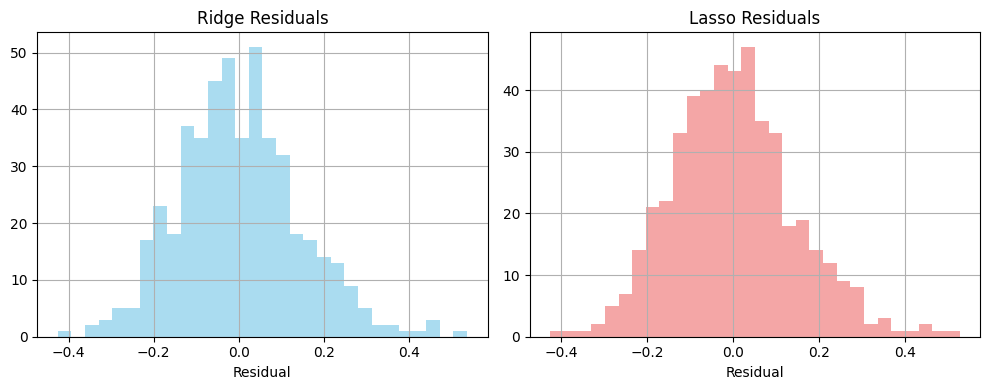

In [22]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
import matplotlib.pyplot as plt

# Step 1: Load your preprocessed dataset
file_path = "modeling_dataset_only.xlsx"
df = pd.read_excel(file_path)

# Step 2: Separate features and target
X = df.drop(columns=["Bed_util_ratio"])
y = df["Bed_util_ratio"]

# Step 3: Standardize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 5: Fit Ridge regression with cross-validation
ridge_alphas = np.logspace(-3, 3, 100)
ridge = RidgeCV(alphas=ridge_alphas, cv=5)
ridge.fit(X_train, y_train)
ridge_preds = ridge.predict(X_test)
ridge_residuals = y_test - ridge_preds

print("\nRidge Regression Results:")
print(f"Best alpha: {ridge.alpha_:.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, ridge_preds)):.4f}")
print(f"Test R²: {r2_score(y_test, ridge_preds):.4f}")

# Shapiro-Wilk test on residuals
stat_ridge, p_ridge = shapiro(ridge_residuals)
print(f"\nShapiro-Wilk Test (Ridge Residuals):")
print(f"W statistic: {stat_ridge:.6f}")
print(f"p-value: {p_ridge:.6f}")
print("Residuals likely normal" if p_ridge > 0.05 else "Residuals likely NOT normal")

# Step 6: Fit Lasso regression with cross-validation
lasso_alphas = np.logspace(-3, 3, 100)
lasso = LassoCV(alphas=lasso_alphas, cv=5, max_iter=5000)
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_test)
lasso_residuals = y_test - lasso_preds

print("\nLasso Regression Results:")
print(f"Best alpha: {lasso.alpha_:.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, lasso_preds)):.4f}")
print(f"Test R²: {r2_score(y_test, lasso_preds):.4f}")

# Shapiro-Wilk test on residuals
stat_lasso, p_lasso = shapiro(lasso_residuals)
print(f"\nShapiro-Wilk Test (Lasso Residuals):")
print(f"W statistic: {stat_lasso:.6f}")
print(f"p-value: {p_lasso:.6f}")
print("Residuals likely normal" if p_lasso > 0.05 else "Residuals likely NOT normal")

# Optional: Plot Residuals
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(ridge_residuals, bins=30, alpha=0.7, color='skyblue')
plt.title("Ridge Residuals")
plt.xlabel("Residual")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(lasso_residuals, bins=30, alpha=0.7, color='lightcoral')
plt.title("Lasso Residuals")
plt.xlabel("Residual")
plt.grid(True)

plt.tight_layout()
plt.show()


# Box-Cox + Ridge/Lasso Regression + Residual Normality Check

Box-Cox Lambda: 0.7952

Ridge Regression Results:
Best alpha: 162.9751
Test RMSE: 0.1826
Test R²: 0.3219

Shapiro-Wilk Test (Ridge Residuals):
W statistic: 0.995824
p-value:     0.234900
Residuals appear normal

Lasso Regression Results:
Best alpha: 0.0013
Test RMSE: 0.1829
Test R²: 0.3199

Shapiro-Wilk Test (Lasso Residuals):
W statistic: 0.996209
p-value:     0.311902
Residuals appear normal


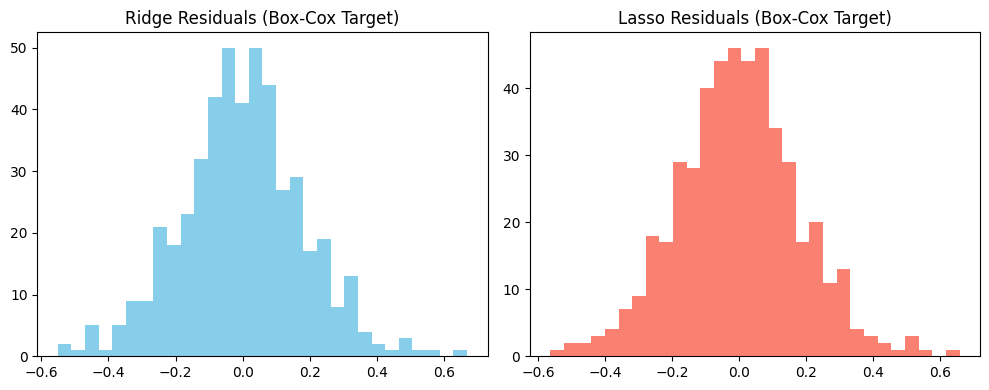


Inverse Transformed RMSEs:
Ridge RMSE (original scale): 0.1433
Lasso RMSE (original scale): 0.1435


In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox, shapiro
import matplotlib.pyplot as plt

# Load data
df = df_model_imputed.copy()

# Split predictors and target
X = df.drop(columns=["Bed_util_ratio"])
y = df["Bed_util_ratio"].copy()

# Apply Box-Cox transformation
# Box-Cox requires all positive values
if (y <= 0).any():
    y += abs(y.min()) + 0.01

y_transformed, lmbda = boxcox(y)
print(f"Box-Cox Lambda: {lmbda:.4f}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

# Scale predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge Regression
ridge = RidgeCV(alphas=np.logspace(-3, 3, 100), cv=5)
ridge.fit(X_train_scaled, y_train)
y_pred_ridge = ridge.predict(X_test_scaled)
residuals_ridge = y_test - y_pred_ridge

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

# Ridge Residual Normality
stat_ridge, p_ridge = shapiro(residuals_ridge)

print("\nRidge Regression Results:")
print(f"Best alpha: {ridge.alpha_:.4f}")
print(f"Test RMSE: {rmse_ridge:.4f}")
print(f"Test R²: {r2_ridge:.4f}")
print("\nShapiro-Wilk Test (Ridge Residuals):")
print(f"W statistic: {stat_ridge:.6f}")
print(f"p-value:     {p_ridge:.6f}")
print("Residuals appear normal" if p_ridge > 0.05 else "Residuals likely NOT normal")

# Lasso Regression
lasso = LassoCV(alphas=np.logspace(-5, 1, 100), cv=5, max_iter=10000)
lasso.fit(X_train_scaled, y_train)
y_pred_lasso = lasso.predict(X_test_scaled)
residuals_lasso = y_test - y_pred_lasso

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

# Lasso Residual Normality
stat_lasso, p_lasso = shapiro(residuals_lasso)

print("\nLasso Regression Results:")
print(f"Best alpha: {lasso.alpha_:.4f}")
print(f"Test RMSE: {rmse_lasso:.4f}")
print(f"Test R²: {r2_lasso:.4f}")
print("\nShapiro-Wilk Test (Lasso Residuals):")
print(f"W statistic: {stat_lasso:.6f}")
print(f"p-value:     {p_lasso:.6f}")
print("Residuals appear normal" if p_lasso > 0.05 else "Residuals likely NOT normal")

# Plot residual histograms
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(residuals_ridge, bins=30, color="skyblue")
plt.title("Ridge Residuals (Box-Cox Target)")

plt.subplot(1, 2, 2)
plt.hist(residuals_lasso, bins=30, color="salmon")
plt.title("Lasso Residuals (Box-Cox Target)")
plt.tight_layout()
plt.show()

# --------------- Inverse the Transormation with Box-Cox --------------------

from scipy.special import inv_boxcox

# Inverse transform predicted values
y_pred_ridge = inv_boxcox(y_pred_ridge, lmbda)
y_pred_lasso = inv_boxcox(y_pred_lasso, lmbda)

# Also inverse y_test for real-world comparison
y_test = inv_boxcox(y_test, lmbda, )

# Compare original RMSE on untransformed scale
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print("\nInverse Transformed RMSEs:")
print(f"Ridge RMSE (original scale): {rmse_ridge:.4f}")
print(f"Lasso RMSE (original scale): {rmse_lasso:.4f}")

# Homoscedasticity Assessment (Residuals vs Predicted Values)

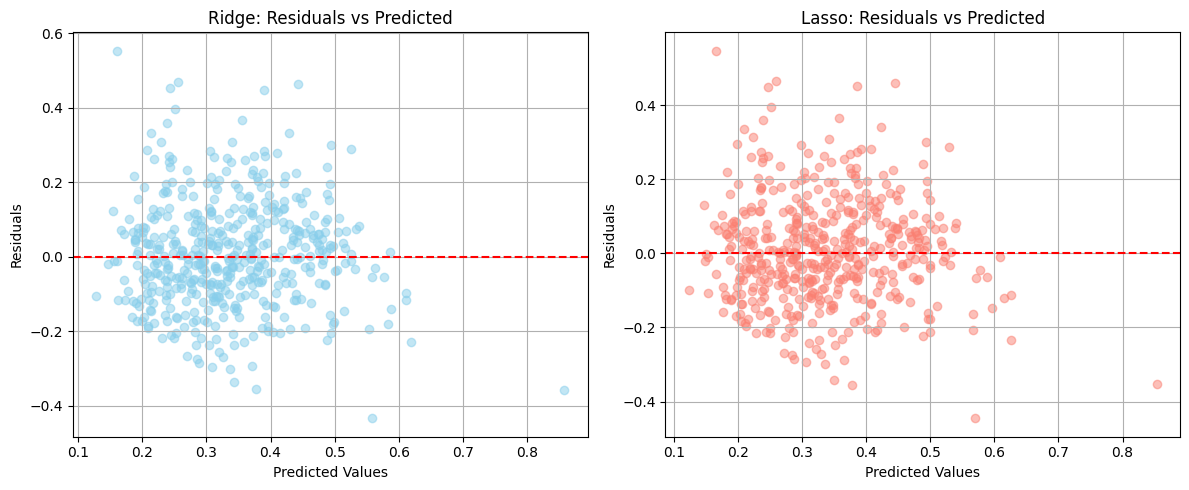

In [24]:
import matplotlib.pyplot as plt

# Recalculate residuals after inverse Box-Cox (if not already done)
residuals_ridge = y_test - y_pred_ridge
residuals_lasso = y_test - y_pred_lasso

plt.figure(figsize=(12, 5))

# Ridge plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred_ridge, residuals_ridge, alpha=0.5, color="skyblue")
plt.axhline(0, color='red', linestyle='--')
plt.title("Ridge: Residuals vs Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)

# Lasso plot
plt.subplot(1, 2, 2)
plt.scatter(y_pred_lasso, residuals_lasso, alpha=0.5, color="salmon")
plt.axhline(0, color='red', linestyle='--')
plt.title("Lasso: Residuals vs Predicted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.grid(True)

plt.tight_layout()
plt.show()


# Heteroscedasticity Check via Breusch-Pagan Test (Residual Variance Test)

In [25]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Add constant to X_test for the BP test
X_test_const = sm.add_constant(X_test)

# Breusch-Pagan test for Ridge
bp_ridge = het_breuschpagan(residuals_ridge, X_test_const)
lm_stat_ridge, lm_p_ridge, f_stat_ridge, f_p_ridge = bp_ridge

print("Breusch-Pagan Test (Ridge Residuals):")
print(f"LM Statistic: {lm_stat_ridge:.3f}, p-value: {lm_p_ridge:.4f}")
print(f"F Statistic:  {f_stat_ridge:.3f}, p-value: {f_p_ridge:.4f}")
print("→ Heteroscedasticity detected!" if lm_p_ridge < 0.05 else "→ Homoscedasticity likely.")

# Breusch-Pagan test for Lasso
bp_lasso = het_breuschpagan(residuals_lasso, X_test_const)
lm_stat_lasso, lm_p_lasso, f_stat_lasso, f_p_lasso = bp_lasso

print("\nBreusch-Pagan Test (Lasso Residuals):")
print(f"LM Statistic: {lm_stat_lasso:.3f}, p-value: {lm_p_lasso:.4f}")
print(f"F Statistic:  {f_stat_lasso:.3f}, p-value: {f_p_lasso:.4f}")
print("→ Heteroscedasticity detected!" if lm_p_lasso < 0.05 else "→ Homoscedasticity likely.")


Breusch-Pagan Test (Ridge Residuals):
LM Statistic: 52.893, p-value: 0.0004
F Statistic:  2.456, p-value: 0.0002
→ Heteroscedasticity detected!

Breusch-Pagan Test (Lasso Residuals):
LM Statistic: 51.768, p-value: 0.0005
F Statistic:  2.397, p-value: 0.0003
→ Heteroscedasticity detected!


# PCA

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

principal = PCA()
principal.fit(X_train_scaled)

principal.explained_variance_ratio_

# explained variance
plt.plot(principal.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Component #')
plt.ylabel('Explained Variance')
plt.show()

# cumulative explained variance
cumulative_variance = np.cumsum(principal.explained_variance_ratio_)
plt.plot(cumulative_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.85, color='r', linestyle='--')
plt.axvline(x=10, color='grey', linestyle='dotted')
plt.show()

print("Explained variance ratio for each component")
print(principal.explained_variance_ratio_)

# start with original set of numeric columns
# project observations onto PCs
latent_features = pd.DataFrame(principal.transform(X_train_scaled))


# start here - I get errors related to "AttributeError: 'numpy.ndarray' object has no attribute 'reset_index'"
# take first 10 col from latent_features
X_train_PCA = pd.concat([latent_features.iloc[:, 0:10].reset_index(drop=True), X_train_scaled.reset_index(drop=True)], axis=1)

# repeat on test set
latent_features_test = pd.DataFrame(principal.transform(X_test_scaled))
X_test_PCA = pd.concat([latent_features_test.iloc[:, 0:10].reset_index(drop=True), X_test_scaled.reset_index(drop=True)], axis=1)